## 라이브러리

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# 한글 처리
plt.rc("font", family = "Malgun Gothic")

# 기호 처리
plt.rcParams["axes.unicode_minus"] = False

---

## 데이터 불러오기

In [34]:
# 데이터 불러오기
df = pd.read_csv('./data/01_자치구_군집분석_데이터.csv', encoding='euc-kr')

# 중복 데이터 제거
idx = df.iloc[:, 1:].drop_duplicates().index
df = df.loc[idx].reset_index(drop=True)

df.head(3)

,지번주소_구,지번주소_동,구면적,2024년06월_1인세대,2024년06월_2인세대,2024년06월_3인세대,2024년06월_4인세대,I 숙박 및 음식점업,Q 보건업 및 사회복지 서비스업,G 도매 및 소매업,20대,30대,40대,50대,60대,총인구 (명),인구 비율,인구 밀도,녹지개소,녹지면적
0,사하구,괴정동,41.77,57405,38271,24265,16171,4420,841,6972,32875,32009,41730,51123,55090,303000,9.19,7254.0,50,28532
1,사하구,다대동,41.77,57405,38271,24265,16171,4420,841,6972,32875,32009,41730,51123,55090,303000,9.19,7254.0,50,28532
2,사하구,당리동,41.77,57405,38271,24265,16171,4420,841,6972,32875,32009,41730,51123,55090,303000,9.19,7254.0,50,28532


---

## Sequential Feature Selector(SFS)

In [35]:
# 문자형 변수 라벨 인코딩
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [36]:
# 자치구 컬럼 제거
df_origin = df.copy()
df = df.drop(columns=['지번주소_구'])

### 전진 선택법

In [4]:
# K-means 모델과 파이프라인 설정
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', kmeans) 
])

# Sequential Feature Selector 설정
sfs = SequentialFeatureSelector(
    pipeline.named_steps['kmeans'],  # K-means 모델 사용
    n_features_to_select='auto',  # 최적의 특성 수를 자동으로 선택
    direction='forward',  # 전진 선택법
    scoring=lambda est, df: silhouette_score(df, est.fit_predict(df)),
    cv=5  # 교차 검증을 사용하여 성능 평가
)

# Sequential Feature Selection 적용
sfs.fit(df)
selected_features = df.columns[sfs.get_support()]
print(f"Selected features(Forward): {selected_features}")

# 선택된 특성들을 이용하여 데이터프레임 생성
selected_features_df = df[selected_features]

# 선택된 특성들을 이용해 파이프라인 학습 및 예측
pipeline.fit(selected_features_df)
labels = pipeline.named_steps['kmeans'].labels_

# 실루엣 계수 계산
silhouette_avg = silhouette_score(selected_features_df, labels)
print(f"Silhouette Score (Forward Selection): {silhouette_avg}")

Selected features(Forward): Index(['구면적', '2024년06월_3인세대', '2024년06월_4인세대', 'I 숙박 및 음식점업',
       'Q 보건업 및 사회복지 서비스업', 'G 도매 및 소매업', '50대', '인구 비율', '녹지개소'],
      dtype='object')
Silhouette Score (Forward Selection): 0.4545386098531768


### 후진 제거법

In [6]:
# K-means 모델과 파이프라인 설정
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', kmeans) 
])

# Sequential Feature Selector 설정
sfs = SequentialFeatureSelector(
    pipeline.named_steps['kmeans'],  # K-means 모델 사용
    n_features_to_select='auto',  # 최적의 특성 수를 자동으로 선택
    direction='backward',  # 후진 선택법
    scoring=lambda est, df: silhouette_score(df, est.fit_predict(df)),
    cv=5  # 교차 검증을 사용하여 성능 평가
)

# Sequential Feature Selection 적용
sfs.fit(df)
selected_features = df.columns[sfs.get_support()]
print(f"Selected features(Backward): {selected_features}")

# 선택된 특성들을 이용하여 데이터프레임 생성
selected_features_df = df[selected_features]

# 선택된 특성들을 이용해 파이프라인 학습 및 예측
pipeline.fit(selected_features_df)
labels = pipeline.named_steps['kmeans'].labels_

# 실루엣 계수 계산
silhouette_avg = silhouette_score(selected_features_df, labels)
print(f"Silhouette Score (Backward Selection): {silhouette_avg}")

Selected features(Backward): Index(['구면적', '2024년06월_1인세대', '2024년06월_2인세대', 'I 숙박 및 음식점업',
       'Q 보건업 및 사회복지 서비스업', 'G 도매 및 소매업', '20대', '총인구 (명)', '인구 비율', '녹지개소'],
      dtype='object')
Silhouette Score (Backward Selection): 0.5396074854457948


- 실루엣 계수가 더 높은 후진 제거법 변수 선택

---

## 자치구 군집 분석

In [37]:
# 후진 제거법 변수
df_b = df[['구면적', '2024년06월_1인세대', '2024년06월_2인세대', 'I 숙박 및 음식점업',
           'Q 보건업 및 사회복지 서비스업', 'G 도매 및 소매업', '20대', '총인구 (명)', 
           '인구 비율', '녹지개소']]

### Kmeans

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9, n_init=10),
                 k=(1, 10))

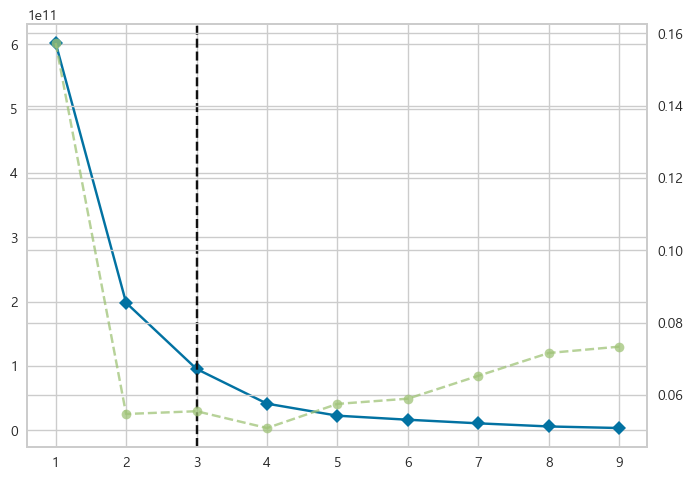

In [162]:
# 엘보우 기법
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(df_b)

In [145]:
# 패턴 찾기 훈련
ss = StandardScaler()
df_b_scaled = ss.fit_transform(df_b)

# 모델생성
km = KMeans(n_clusters=3, n_init=10, random_state=42)

# 훈련
km.fit(df_b_scaled)

# 군집 결과 확인
df_b = df_b.copy()
df_b.loc[:, 'clust'] = km.labels_

np.unique(km.labels_, return_counts=True)

(array([0, 1, 2]), array([37, 13, 17], dtype=int64))

In [164]:
# 실루엣 계수
silhouette_avg = silhouette_score(df_b_scaled, km.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5656333854982614


In [146]:
# Kmeans 군집 결과
df_b_result = pd.concat([df_b, df_origin[['지번주소_구']]], axis=1).drop_duplicates()
df_b_result.head(3)

,구면적,2024년06월_1인세대,2024년06월_2인세대,I 숙박 및 음식점업,Q 보건업 및 사회복지 서비스업,G 도매 및 소매업,20대,총인구 (명),인구 비율,녹지개소,clust,지번주소_구
0,41.77,57405,38271,4420,841,6972,32875,303000,9.19,50,0,9
6,12.10,38853,26321,3236,711,5543,23137,199751,6.06,15,0,12
8,65.28,47432,27387,3743,690,6256,27696,227484,6.90,32,0,1


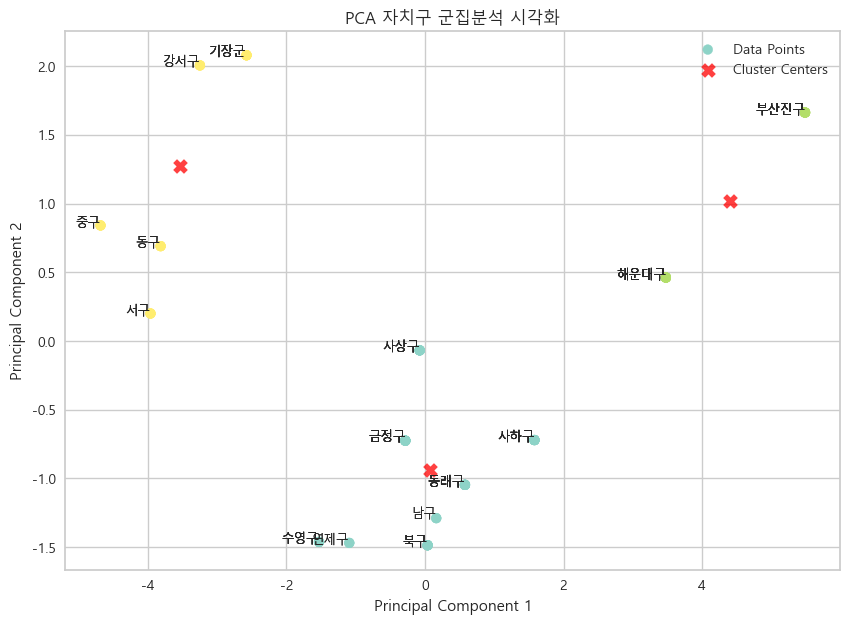

In [165]:
# '지번주소_구'에 대해 2D array를 1D array로 변환
temp = pd.concat([pd.DataFrame(df_b_scaled), df_b[['clust']], df_origin[['지번주소_구']]], axis=1)
temp['지번주소_구'] = label_encoders['지번주소_구'].inverse_transform(temp[['지번주소_구']].values.ravel())

# PCA 수행
pca = PCA(n_components=2)
X_pca = pca.fit_transform(temp.iloc[:, :-2])
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca = pd.concat([X_pca, temp.iloc[:, -2], temp[['지번주소_구']]], axis=1)

# 시각화
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca['PC1'], X_pca['PC2'], c=X_pca['clust'], s=50, cmap='Set3', label='Data Points')
centers_pca = pca.transform(km.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=100, alpha=0.75, marker='X', label='Cluster Centers')

# 텍스트 추가
for i in range(X_pca.shape[0]):
    plt.text(X_pca['PC1'][i], X_pca['PC2'][i], X_pca['지번주소_구'][i], fontsize=9, ha='right')

plt.title('PCA 자치구 군집분석 시각화')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.savefig('./savefig/PCA_자치구군집분석_시각화.png')

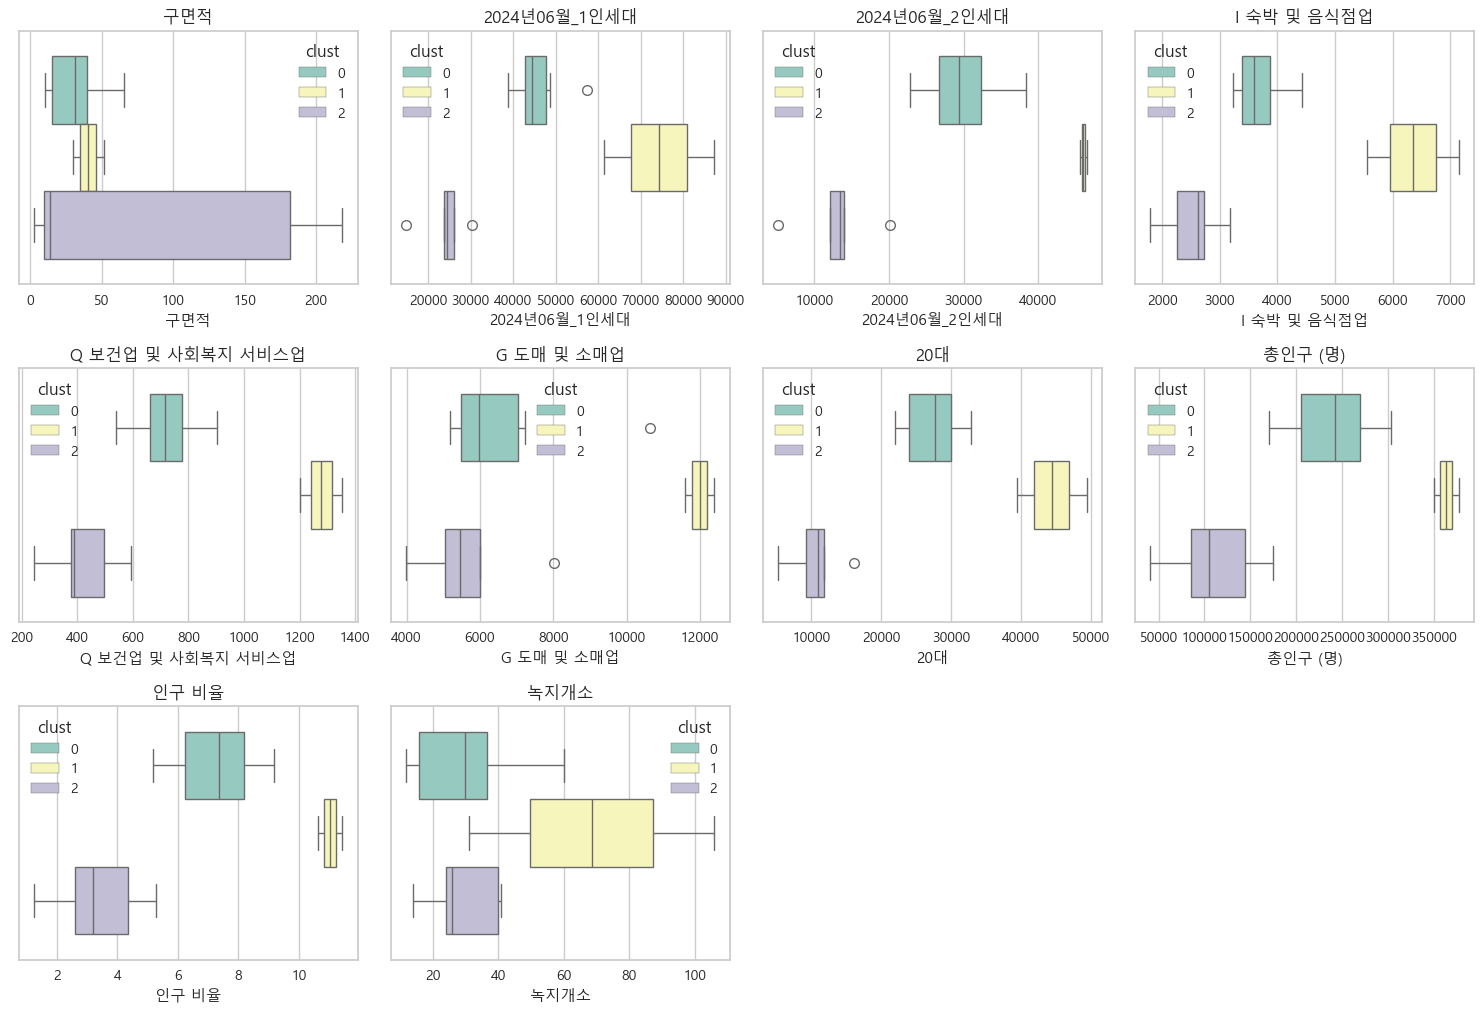

In [154]:
# 자치구별 군집분석 컬럼 시각화
i = 1
plt.figure(figsize=(15,20))

for val in df_b_result.columns[:-2]:
    plt.subplot(6,4,i)
    sns.boxplot(data=df_b_result, x=val, hue='clust', palette='Set3')
    plt.title(val)
    plt.tight_layout()
    i += 1
plt.savefig('./savefig/자치구별군집분석컬럼시각화.png')

In [161]:
# 군집 확인
temp = pd.concat([df_b[['clust']], df_origin[['지번주소_구']]], axis=1)
temp['지번주소_구'] = label_encoders['지번주소_구'].inverse_transform(temp[['지번주소_구']].values.ravel())

temp = temp.drop_duplicates().sort_values(by='clust')
temp

,clust,지번주소_구
0,0,사하구
6,0,연제구
8,0,금정구
21,0,동래구
36,0,사상구
41,0,남구
43,0,수영구
47,0,북구
27,1,부산진구
52,1,해운대구


### 자치구 가중치

스마트팜 서비스에 대한 수요가 예상되는 항목을 선정하여 점수 부여

| 항목 | 0 | 1 | 2 |
| ------ | ------ | ------ | ------ |
| 숙박 및 음식점 비율 낮은 순 | 2 | 1 | 3 |
| 보건업 및 복지 비율 높은 순 | 2 | 3 | 1 |
| 20대 인구 수 높은 순 | 2 | 3 | 1 |
| 녹지 개소 적은 순 | 2 | 3 | 1 |
| 인구 비율 높은 순 | 2 | 3 | 1 |
| 합계 | 10 | 13 | 7 |
| 자치구 가중치 | 0.5 | 1.0 | 0.0 |

- 각 군집의 중앙값을 비교하여, 3점에서 1점까지의 점수를 부여
- 이를 합산한 후 Min-Max Scaling을 적용하여 자치구 가중치 결정